# Task 2: Rumour Analysis

In [4]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import metaknowledge as mk
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import gensim
from gensim import corpora, models
from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import seaborn as sns
import matplotlib.colors as mcolors

### Data pre process

In [5]:
covid_df = pd.read_csv('./project-data/convid.csv')
covid_text = pd.read_csv('./project-data/covid_tweet_df.csv')
covid = pd.merge(covid_df, covid_text, on='tweet_id')

In [7]:
rumour_covid = covid.loc[covid['label'] == 1]
non_rumour_covid = covid.loc[covid['label'] == 0]

### Question1: What are the topics of COVID-19 rumours, and how do they differ from the non-rumours?

#### LDA model with 5 topics

In [8]:
def lda_preprocess(df):
    docs = np.asarray(df['text_y'])

    phrase = []
    for line in docs:
        if line is not np.nan:
            line = line.split()

            phrase.append([w for w in line])
            
    dictionary = corpora.Dictionary(phrase)
    corpus = [dictionary.doc2bow(text) for text in phrase]

    return phrase, dictionary, corpus

In [9]:
def lda_model(dictionary, corpus):
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=5, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=10,
                                               passes=20,
                                               alpha='symmetric',
                                               iterations=100,
                                               per_word_topics=True)
    return(lda)

In [10]:
rumour_phrase, rumour_dictionary, rumour_corpus = lda_preprocess(rumour_covid)
rumour_lda = lda_model(rumour_dictionary, rumour_corpus)

In [75]:
non_rumour_phrase, non_rumour_dictionary, non_rumour_corpus = lda_preprocess(non_rumour_covid)
non_rumour_lda = lda_model(non_rumour_dictionary, non_rumour_corpus)

In [24]:
def print_topics(data,title):
    words = []
    for i in data:
        a = ""
        for b in i[1]:
            a += str(b[0])
            a += " "
        words.append(a)
    return words


In [27]:
print(rumour_topics)

['coronaviru death test american news pandem think million stop today ', 'trump covid go report donald due never administr countri ask ', 'new case coronaviru one said biden florida joe daili respons ', 'say presid coronaviru break us china mask need state announc ', 'coronaviru peopl get time claim ralli day fauci back health ']


In [11]:
print(rumour_lda.show_topics(formatted=False))

[(0, [('coronaviru', 0.060918387), ('death', 0.034618407), ('test', 0.027775666), ('american', 0.025252499), ('news', 0.02301344), ('pandem', 0.021436926), ('think', 0.017589401), ('million', 0.01525609), ('stop', 0.01335377), ('today', 0.012883466)]), (1, [('trump', 0.14555407), ('covid', 0.07181606), ('go', 0.021519698), ('report', 0.018975565), ('donald', 0.0113582695), ('due', 0.010888032), ('never', 0.010111641), ('administr', 0.0090864925), ('countri', 0.009072033), ('ask', 0.0076076803)]), (2, [('new', 0.04784656), ('case', 0.04031576), ('coronaviru', 0.036494043), ('one', 0.025222816), ('said', 0.018751971), ('biden', 0.017987726), ('florida', 0.017734947), ('joe', 0.012231403), ('daili', 0.011726026), ('respons', 0.011570392)]), (3, [('say', 0.043797884), ('presid', 0.043487288), ('coronaviru', 0.033193603), ('break', 0.028081447), ('us', 0.017720997), ('china', 0.016331226), ('mask', 0.015473216), ('need', 0.012833012), ('state', 0.0125283245), ('announc', 0.011324133)]), (4,

In [26]:
rumour_topics = print_topics(rumour_lda.show_topics(formatted=False),"Topics in rumour")

In [117]:
print_topics(non_rumour_lda.show_topics(formatted=False),"Topics in non-rumour")

Topics in non-rumour
Topic  0
go one day world know spread due show care mani 
Topic  1
test break say health govern announc social die mask updat 
Topic  2
new posit hospit take place help month offici crisi learn 
Topic  3
covid case today state confirm pandem need patient open get 
Topic  4
coronaviru death peopl us week report time live may uk 


In [77]:
def get_topic_words(topics):
    dict_words = {}
    for i in topics:
        for b in i[1]:
            if b in dict_words.keys():
                dict_words[b[0]] += b[1]
            else:
                dict_words[b[0]] = b[1]
    return dict_words

In [79]:
rumour_words = get_topic_words(rumour_lda.show_topics(formatted=False))
non_rumour_words = get_topic_words(non_rumour_lda.show_topics(formatted=False))
print("Same topic words", set(rumour_words.keys())&(set(non_rumour_words.keys())))
print("Only in rumour topics:", set(rumour_words.keys())-(set(non_rumour_words.keys())))
print("Only in non_rumour topics:",set(non_rumour_words.keys())-(set(rumour_words.keys())))

Same topic words {'one', 'health', 'new', 'say', 'break', 'time', 'mask', 'announc', 'coronaviru', 'go', 'case', 'day', 'peopl', 'pandem', 'covid', 'due', 'us', 'need', 'test', 'get', 'today', 'death', 'report', 'state'}
Only in rumour topics: {'think', 'florida', 'administr', 'ask', 'trump', 'daili', 'million', 'stop', 'news', 'american', 'respons', 'china', 'back', 'biden', 'ralli', 'countri', 'claim', 'joe', 'donald', 'presid', 'fauci', 'never', 'said'}
Only in non_rumour topics: {'live', 'help', 'world', 'hospit', 'crisi', 'take', 'offici', 'open', 'month', 'patient', 'care', 'social', 'learn', 'confirm', 'spread', 'know', 'posit', 'show', 'die', 'week', 'uk', 'govern', 'updat', 'place', 'may', 'mani'}


### pyLDAVis

In [50]:
rumour_vis_data = gensimvis.prepare(rumour_lda, rumour_corpus, rumour_dictionary)
#pyLDAvis.show(rumour_vis_data, local=False)
pyLDAvis.save_html(rumour_vis_data, 'lda_r.html')

C:\Users\81520\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [51]:
non_rumour_vis_data = gensimvis.prepare(non_rumour_lda, non_rumour_corpus, non_rumour_dictionary)
#pyLDAvis.show(rumour_vis_data, local=False)
pyLDAvis.save_html(non_rumour_vis_data, 'lda_n.html')

C:\Users\81520\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### T-SNE Clustering Chart

In [15]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label, HoverTool
from bokeh.io import output_notebook

# Get topic weights
def t_sne(lda, corpus):
    topic_weights = []
    for i, row_list in enumerate(lda[corpus]):
        topic_weights.append([w for i, w in row_list[0]])

    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values

    # Keep the well separated points (optional)
    arr = arr[np.amax(arr, axis=1) > 0.35]

    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)

    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)

    # Plot the Topic Clusters using Bokeh
    output_notebook()
    n_topics = 5
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title="t-SNE Clustering of {} LDA Rumours Topics".format(n_topics), 
                  plot_width=900, plot_height=700)
    plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num], source=bp .ColumnDataSource({
        "content": news[:num_example],"topic_key": _lda_keys[:num_example]}))
    # hover tools
    hover = plot .select(dict(type =HoverTool))
    hover .tooltips = {"content": "@content - topic: @topic_key"}
    # save the plot
    show(plot)
    

In [16]:
t_sne(rumour_lda, rumour_corpus)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4473 samples in 0.003s...
[t-SNE] Computed neighbors for 4473 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4473
[t-SNE] Computed conditional probabilities for sample 2000 / 4473
[t-SNE] Computed conditional probabilities for sample 3000 / 4473
[t-SNE] Computed conditional probabilities for sample 4000 / 4473
[t-SNE] Computed conditional probabilities for sample 4473 / 4473
[t-SNE] Mean sigma: 0.069673


C:\Users\81520\anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
C:\Users\81520\anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current

[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.631126


C:\Users\81520\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\81520\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1000 iterations: 1.021515


Loading BokehJS ...

In [43]:
t_sne(non_rumour_lda, non_rumour_corpus)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8507 samples in 0.007s...
[t-SNE] Computed neighbors for 8507 samples in 0.352s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8507
[t-SNE] Computed conditional probabilities for sample 2000 / 8507
[t-SNE] Computed conditional probabilities for sample 3000 / 8507
[t-SNE] Computed conditional probabilities for sample 4000 / 8507
[t-SNE] Computed conditional probabilities for sample 5000 / 8507
[t-SNE] Computed conditional probabilities for sample 6000 / 8507
[t-SNE] Computed conditional probabilities for sample 7000 / 8507
[t-SNE] Computed conditional probabilities for sample 8000 / 8507
[t-SNE] Computed conditional probabilities for sample 8507 / 8507
[t-SNE] Mean sigma: 0.054900


C:\Users\81520\anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
C:\Users\81520\anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current

[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.070107


C:\Users\81520\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\81520\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1000 iterations: 1.045882


Loading BokehJS ...

In [38]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=rumour_lda, corpus=rumour_corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in rumour_lda.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

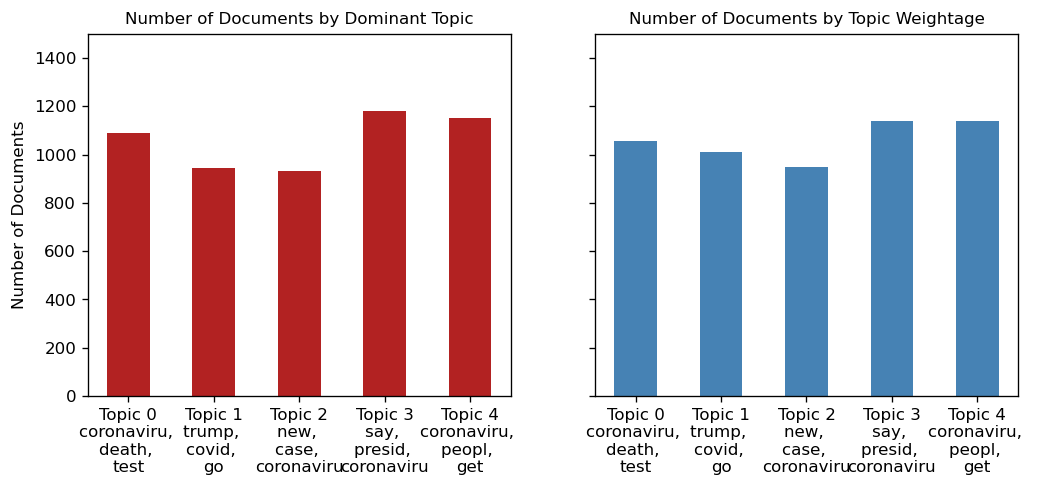

In [40]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1500)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### Question2: How do COVID-19 rumour topics or trends evolve over time?

In [1]:
import time
from time import strptime
from datetime import datetime
from time import mktime

In [2]:
#2020-04-15 01:49:11+00:00
def time_process(df):
    df["struc_time"] = df["created_at"].apply(lambda x: strptime(x.split('+')[0],  '%Y-%m-%d %H:%M:%S'))
    df["time"] = df['struc_time'].apply(lambda x: datetime.fromtimestamp(mktime(x)))
    
    return df

In [33]:
time_process(rumour_covid)
time_process(non_rumour_covid)

<ipython-input-32-e05b35c2da7f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["struc_time"] = df["created_at"].apply(lambda x: strptime(x.split('+')[0],  '%Y-%m-%d %H:%M:%S'))
<ipython-input-32-e05b35c2da7f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = df['struc_time'].apply(lambda x: datetime.fromtimestamp(mktime(x)))
<ipython-input-32-e05b35c2da7f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,Unnamed: 0.1,Unnamed: 0,reply_user_engagement,reply_contributors,reply_favourite_rate,reply_possibly_sensitive,reply_possibly_sensitive_appealable,reply_following_rate,reply_retweet_count,reply_favorite_count,...,notifications,label,text_x,senti_score,created_at,hashtags,text_y,reply_text,struc_time,time
0,0,0,17188.262500,0.0,5173.112500,0.0,0.0,0.0,0.5,4.500000,...,False,0,During the overhyped coronavirus and the rioti...,0.800000,2020-06-03 11:01:44+00:00,NaN,overhyp coronaviru riot wit first hand happen ...,understand one bad cop kill person caus hundr ...,"(2020, 6, 3, 11, 1, 44, 2, 155, -1)",2020-06-03 11:01:44
1,1,1,1051.636364,0.0,175.818182,0.0,0.0,0.0,0.0,0.000000,...,False,0,As another 563 people in the UK lose their liv...,0.000000,2020-04-01 14:25:14+00:00,Coronavirus,anoth peopl uk lose live coronaviru bori johns...,today bbc prime minist bori johnson issu video...,"(2020, 4, 1, 14, 25, 14, 2, 92, -1)",2020-04-01 14:25:14
3,3,3,2582.650000,0.0,2215.533333,0.0,0.0,0.0,0.0,0.000000,...,False,0,Dear @NCDCgov &amp; @followlasg \n\nThis is a ...,0.000000,2020-04-29 17:04:32+00:00,COVID19,dear distress call help friend suspect,relationship dose countri insuffici insuffici ...,"(2020, 4, 29, 17, 4, 32, 2, 120, -1)",2020-04-29 17:04:32
4,4,4,5813.576923,0.0,11923.641026,0.0,0.0,0.0,0.5,107.500000,...,False,0,hey quick q how come coronavirus vaccine resea...,0.166667,2020-07-17 17:39:55+00:00,NaN,hey quick q come coronaviru vaccin research fu...,assum bc compani scientist work want profit bc...,"(2020, 7, 17, 17, 39, 55, 4, 199, -1)",2020-07-17 17:39:55
5,5,5,153.277778,0.0,4857.972222,0.0,0.0,0.0,0.0,13.666667,...,False,0,In most countries the majority of people is sa...,0.500000,2020-06-16 12:54:35+00:00,NaN,countri major peopl satisfi respons covid,brazil action taken head state fight [SEP] tho...,"(2020, 6, 16, 12, 54, 35, 1, 168, -1)",2020-06-16 12:54:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15959,15959,15959,8.666667,0.0,2.000000,0.0,0.0,0.0,0.0,0.000000,...,False,0,"In times of #COVID19, many of us have fallen p...",0.362500,2020-05-06 12:20:49+00:00,COVID19 bats,time mani us fallen prey rumour bat bebo fruit...,NaN,"(2020, 5, 6, 12, 20, 49, 2, 127, -1)",2020-05-06 12:20:49
15961,15961,15961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0,Today marks 3 weeks since daycares (&lt;4) re-...,0.191667,2020-06-01 22:31:08+00:00,NaN,today mark week sinc daycar open full capac ne...,NaN,"(2020, 6, 1, 22, 31, 8, 0, 153, -1)",2020-06-01 22:31:08
15962,15962,15962,3541.460516,0.0,1368.583383,0.0,0.0,0.0,91.5,129.750000,...,False,0,NEW: Sat 4 April update of coronavirus traject...,0.174545,2020-04-04 20:40:47+00:00,NaN,new sat april updat coronaviru trajectori dail...,look cumul us death toll slope show sign shoot...,"(2020, 4, 4, 20, 40, 47, 5, 95, -1)",2020-04-04 20:40:47
15963,15963,15963,796.141667,0.0,1035.816667,0.0,0.0,0.0,0.2,1.400000,...,False,0,https://t.co/83W4jRiUKU,0.000000,2020-05-21 23:43:46+00:00,NaN,NaN,disaponit sad news us allah give us rileef [SE...,"(2020, 5, 21, 23, 43, 46, 3, 142, -1)",2020-05-21 23:43:46


### rumour data over quarters

In [34]:
#time from 2020-01 to 2020-08-01
rumour_1 = rumour_covid[(rumour_covid.time > "2020-01") & (rumour_covid.time < "2020-03")]
rumour_2 = rumour_covid[(rumour_covid.time > "2020-03") & (rumour_covid.time < "2020-06")]
rumour_3 = rumour_covid[(rumour_covid.time > "2020-06") & (rumour_covid.time < "2020-09")]

rumour_1_phrase, rumour_1_dictionary, rumour_1_corpus = lda_preprocess(rumour_1)
rumour_lda_1 = lda_model(rumour_1_dictionary, rumour_1_corpus)
rumour_lda_topics_1 = rumour_lda_1.show_topics(formatted=False)

rumour_2_phrase, rumour_2_dictionary, rumour_2_corpus = lda_preprocess(rumour_2)
rumour_lda_2 = lda_model(rumour_2_dictionary, rumour_2_corpus)
rumour_lda_topics_2 = rumour_lda_2.show_topics(formatted=False)

rumour_3_phrase, rumour_3_dictionary, rumour_3_corpus = lda_preprocess(rumour_3)
rumour_lda_3 = lda_model(rumour_3_dictionary, rumour_3_corpus)
rumour_lda_topics_3 = rumour_lda_3.show_topics(formatted=False)

KeyboardInterrupt: 

In [ ]:
non_rumour_1 = non_rumour_covid[(non_rumour_covid.time > "2020-01") & (non_rumour_covid.time < "2020-03")]
non_rumour_2 = non_rumour_covid[(non_rumour_covid.time > "2020-03") & (non_rumour_covid.time < "2020-06")]
non_rumour_3 = non_rumour_covid[(non_rumour_covid.time > "2020-06") & (non_rumour_covid.time < "2020-09")]

non_rumour_1_phrase, non_rumour_1_dictionary, non_rumour_1_corpus = lda_preprocess(non_rumour_1)
non_rumour_lda_1 = lda_model(non_rumour_1_dictionary, non_rumour_1_corpus)
non_rumour_lda_topics_1 = non_rumour_lda_1.show_topics(formatted=False)

non_rumour_2_phrase, non_rumour_2_dictionary, non_rumour_2_corpus = lda_preprocess(non_rumour_2)
non_rumour_lda_2 = lda_model(non_rumour_2_dictionary, non_rumour_2_corpus)
non_rumour_lda_topics_2 = non_rumour_lda_2.show_topics(formatted=False)

non_rumour_3_phrase, non_rumour_3_dictionary, non_rumour_3_corpus = lda_preprocess(non_rumour_3)
non_rumour_lda_3 = lda_model(non_rumour_3_dictionary, non_rumour_3_corpus)
non_rumour_lda_topics_3 = non_rumour_lda_3.show_topics(formatted=False)

In [124]:
print_topics(rumour_lda_topics_1,"Topics of rumour in the first quarter")
print("----------------------------------------------------")
print_topics(non_rumour_lda_topics_1,"Topics of non_rumour in the first quarter")

Topics of rumour in the first quarter
Topic  0
trump coronaviru cdc ye charg stori administr news noth common 
Topic  1
coronaviru presid south case call public health polici american televangelist 
Topic  2
one limbaugh flu cancel democrat viru larg new live worri 
Topic  3
coronaviru say china trump chines administr think fight god pastor 
Topic  4
mike penc peopl trump let nation state go hiv everi 
----------------------------------------------------
Topics of non_rumour in the first quarter
Topic  0
coronaviru spread respons public health updat state februari mmwr offici 
Topic  1
outbreak prevent diseas confirm us know presid around test case 
Topic  2
china wuhan say break univers contain thread realli flight south 
Topic  3
coronaviru new continu world task make sure peopl current border 
Topic  4
covid cdc unit diseas militari pleas coronaviru first morn exist 


In [125]:
print_topics(rumour_lda_topics_2,"Topics of rumour in the second quarter")
print("----------------------------------------------------")
print_topics(non_rumour_lda_topics_2,"Topics of non_rumour in the second quarter")

Topics of rumour in the second quarter
Topic  0
trump coronaviru presid american time million respons today call first 
Topic  1
coronaviru death us test hous claim white long week highest 
Topic  2
coronaviru covid new say case china one need report stop 
Topic  3
break pandem go biden get fauci democrat fox brief take 
Topic  4
peopl news day chines donald said happen come offici would 
----------------------------------------------------
Topics of non_rumour in the second quarter
Topic  0
coronaviru bat mani die uk presid use live get even 
Topic  1
test peopl one posit world may take would pay sat 
Topic  2
covid case today break state govern lockdown confirm week worker 
Topic  3
go say time health april updat day hospit announc daili 
Topic  4
coronaviru new death us clear report patient social spain increas 


In [126]:
print_topics(rumour_lda_topics_3,"Topics of rumour in the thrid quarter")
print("----------------------------------------------------")
print_topics(non_rumour_lda_topics_3,"Topics of non_rumour in the thrid quarter")

Topics of rumour in the thrid quarter
Topic  0
say death covid said get go american tulsa kill plan 
Topic  1
peopl florida coronaviru think texa like surg parti sick arizona 
Topic  2
back want attend covid today announc great juli us news 
Topic  3
trump coronaviru ralli test mask campaign pandem one state biden 
Topic  4
coronaviru presid case new covid report break sinc day america 
----------------------------------------------------
Topics of non_rumour in the thrid quarter
Topic  0
coronaviru state need day two due vaccin month die close 
Topic  1
covid test break new peopl say mask wear pandem countri 
Topic  2
case covid today one time report govern get know million 
Topic  3
week american infect us counti could black like ask point 
Topic  4
posit health death announc spread rise live may confirm warn 


In [32]:
rumour_words_1 = get_topic_words(rumour_lda_topics_1)
rumour_words_2 = get_topic_words(rumour_lda_topics_2)
rumour_words_3 = get_topic_words(rumour_lda_topics_3)
new_rumour_1 = set(rumour_words_2.keys()).difference(set(rumour_words_1.keys()))
new_rumour_2 = set(rumour_words_3.keys()).difference(set(rumour_words_2.keys()))
print("Topic words in all of three quarters:", (set(rumour_words_2.keys())&(set(rumour_words_1.keys())))&set(rumour_words_3.keys()))
print("New topic words in the second quarter:", new_rumour_1)
print("New topic words in the third quarter:", new_rumour_2)
print("New topic words in the second quarter, and keep in third quarter:",new_rumour_1&set(rumour_words_3.keys()))

Topic words in all of three quarters: {'one', 'new', 'coronaviru', 'news', 'say', 'go', 'presid', 'american', 'case', 'peopl', 'trump'}
New topic words in the second quarter: {'first', 'hous', 'happen', 'break', 'white', 'million', 'time', 'fox', 'stop', 'take', 'day', 'come', 'brief', 'offici', 'pandem', 'covid', 'respons', 'us', 'need', 'biden', 'long', 'test', 'get', 'claim', 'today', 'donald', 'death', 'would', 'week', 'highest', 'report', 'fauci', 'said'}
New topic words in the third quarter: {'think', 'florida', 'tulsa', 'arizona', 'mask', 'announc', 'great', 'america', 'back', 'surg', 'ralli', 'parti', 'juli', 'plan', 'attend', 'kill', 'sick', 'want', 'texa', 'sinc', 'like', 'state', 'campaign'}
New topic words in the second quarter, and keep in third quarter: {'covid', 'death', 'us', 'said', 'biden', 'report', 'test', 'get', 'day', 'today', 'break', 'pandem'}


In [48]:
non_rumour_words_1 = get_topic_words(non_rumour_lda_topics_1)
non_rumour_words_2 = get_topic_words(non_rumour_lda_topics_2)
non_rumour_words_3 = get_topic_words(non_rumour_lda_topics_3)
non_new_rumour_1 = set(non_rumour_words_2.keys())-(set(non_rumour_words_1.keys()))
non_new_rumour_2 = set(non_rumour_words_3.keys())-(set(non_rumour_words_2.keys()))
print("Topic words in all of three quarters:", (set(non_rumour_words_2.keys())&(set(non_rumour_words_1.keys())))&set(non_rumour_words_3.keys()))
print("New topic words in the second quarter:", non_new_rumour_1)
print("New topic words in the third quarter:", non_new_rumour_2)
print("New topic words in the second quarter, and keep in third quarter:",non_new_rumour_1&set(non_rumour_words_3.keys()))

Topic words in all of three quarters: {'covid', 'us', 'health', 'new', 'coronaviru', 'say', 'test', 'case', 'peopl', 'state', 'confirm', 'break'}
New topic words in the second quarter: {'april', 'one', 'pay', 'live', 'sat', 'daili', 'hospit', 'time', 'announc', 'bat', 'go', 'take', 'day', 'patient', 'worker', 'get', 'clear', 'social', 'today', 'increas', 'death', 'even', 'posit', 'would', 'die', 'week', 'use', 'uk', 'govern', 'lockdown', 'report', 'spain', 'may', 'mani'}
New topic words in the third quarter: {'ask', 'rise', 'wear', 'million', 'mask', 'counti', 'american', 'close', 'could', 'infect', 'pandem', 'due', 'month', 'need', 'warn', 'countri', 'spread', 'know', 'vaccin', 'point', 'two', 'like', 'black'}
New topic words in the second quarter, and keep in third quarter: {'death', 'time', 'one', 'posit', 'live', 'announc', 'die', 'week', 'govern', 'report', 'get', 'day', 'may', 'today'}


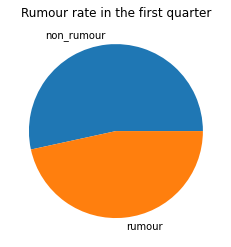

In [53]:
plt.title('Rumour rate in the first quarter') 
rumour_1_rates = [len(non_rumour_1), len(rumour_1)]
plt.pie(rumour_1_rates, labels = ['non_rumour', 'rumour'])
plt.show()

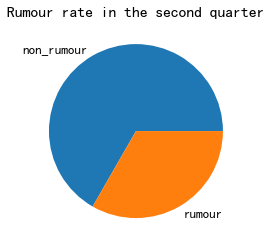

In [143]:
plt.title('Rumour rate in the second quarter') 
rumour_2_rates = [len(non_rumour_2), len(rumour_2)]
plt.pie(rumour_2_rates, labels = ['non_rumour', 'rumour'])
plt.show()

In [145]:
print(len(non_rumour_2), len(rumour_2))

7164 3576


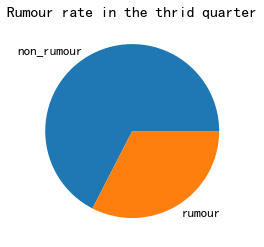

In [64]:
plt.title('Rumour rate in the thrid quarter') 
rumour_3_rates = [len(non_rumour_3), len(rumour_3)]
plt.pie(rumour_3_rates, labels = ['non_rumour', 'rumour'])
plt.show()

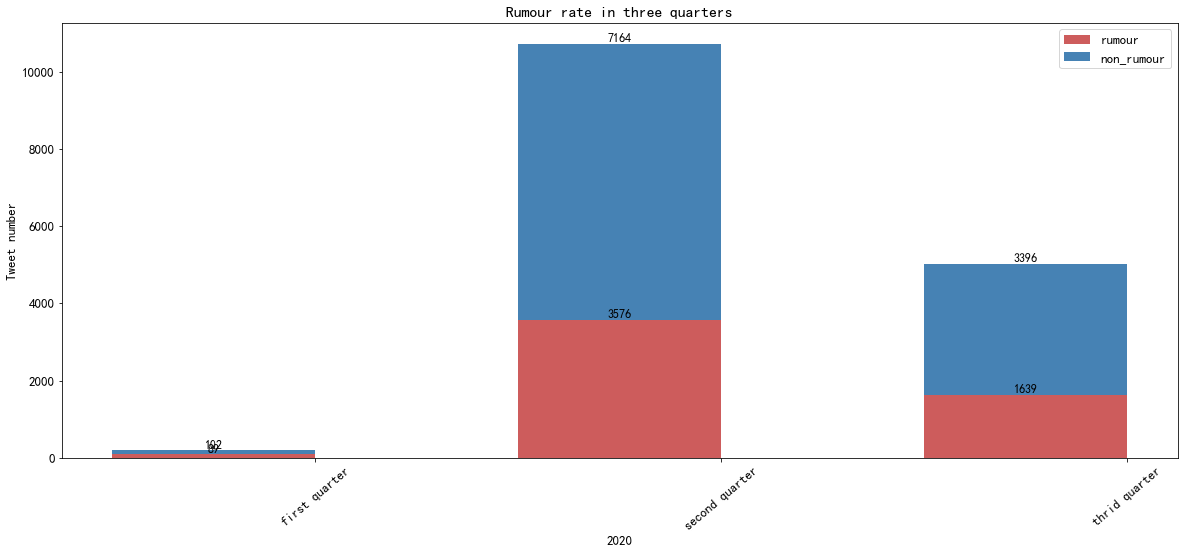

In [142]:
num = rumour+non_rumour
ratio = rumour/num
rumour = np.array([len(rumour_1), len(rumour_2), len(rumour_3)])
non_rumour = np.array([len(non_rumour_1), len(non_rumour_2), len(non_rumour_3)])

x = ['first quarter','second quarter','thrid quarter']
width = 0.5
plt.figure(figsize=(20, 8))
idx = np.arange(len(x))
plt.title('Rumour rate in three quarters') 
plt.bar(idx, rumour, width, color='indianred', label='rumour')
plt.bar(idx, non_rumour, width, bottom=rumour, color='steelblue', label='non_rumour')
plt.xlabel('2020')
plt.ylabel('Tweet number')
plt.xticks(idx+width/2, x, rotation=40)

for a,b in zip(idx,rumour):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=12)
for a,b,c in zip(idx,non_rumour,rumour):
    plt.text(a, b+c+0.5, '%.0f' % b, ha='center', va= 'bottom',fontsize=12)
plt.legend()
plt.show()

### Question3: What are the popular hashtags of COVID-19 rumours and non-rumours? How much overlap or difference do they share?

In [29]:
from collections import Counter

C:\Users\81520\anaconda3\lib\site-packages\seaborn\categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\81520\anaconda3\lib\site-packages\seaborn\categorical.py:332: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
C:\Users\81520\anaconda3\lib\site-packages\sea

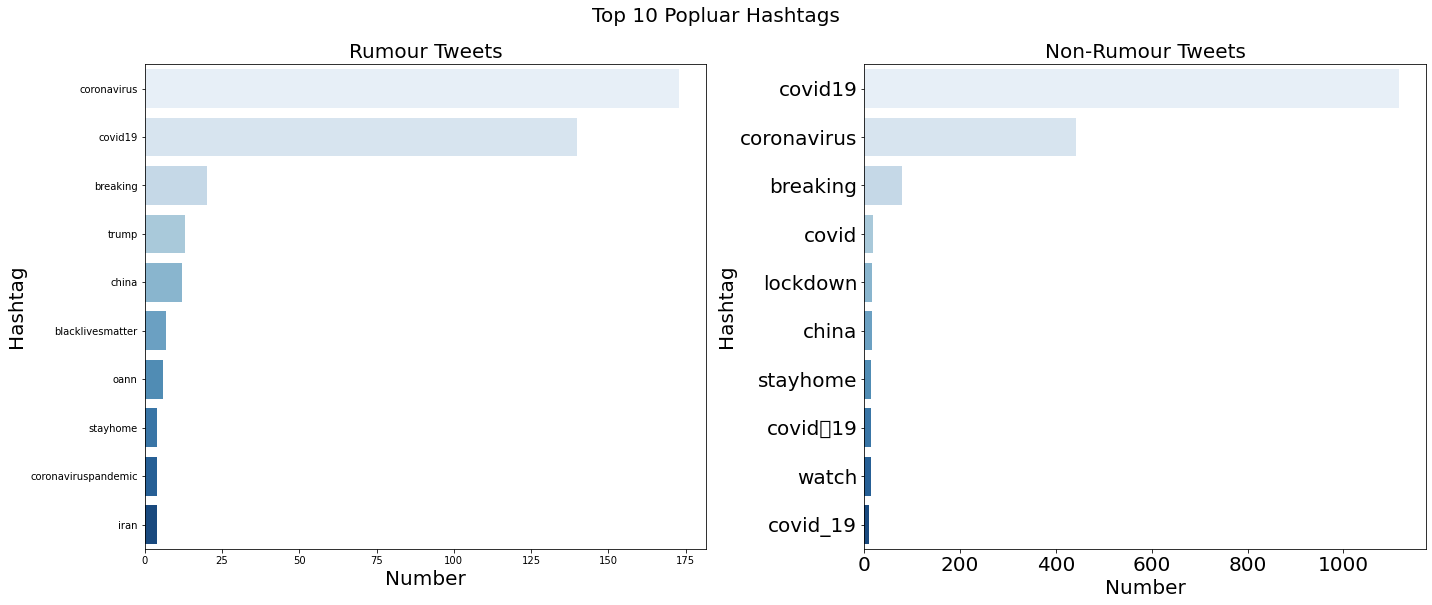

In [52]:
def hashtags_process(df):
    docs = np.asarray(df['hashtags'])
    hashtags = []
    for line in docs:
        if line is not np.nan:
            line = line.split()
            for w in line:
                hashtags.append(w.lower())
    return hashtags

hashtags = [hashtags_process(rumour_covid), hashtags_process(non_rumour_covid)]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tick_params(labelsize=20)
axes = axes.flatten()

compare = []
for i, j in zip(hashtags, axes):
    counter = Counter(i)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:10]:
        x.append(word)
        y.append(count)
    compare.append(x)
    sns.barplot(x=y, y=x, palette='Blues' , ax=j)

axes[0].set_title('Rumour Tweets', fontsize=20)
axes[1].set_title('Non-Rumour Tweets', fontsize=20)

axes[0].set_xlabel('Number', fontsize=20)
axes[0].set_ylabel('Hashtag', fontsize=20)
axes[1].set_xlabel('Number', fontsize=20)
axes[1].set_ylabel('Hashtag', fontsize=20)

fig.suptitle('Top 10 Popluar Hashtags\n', fontsize=20, va='baseline')
plt.tight_layout()

In [162]:
print("Same hashtags:", set(compare[0])&(set(compare[1])))
print("Hashtags in rumour, but not in non_rumour:", set(compare[0])-(set(compare[1])))
print("Hashtags in non_rumour, but not in rumour:", set(compare[1])-(set(compare[0])))

Same hashtags: {'china', 'coronavirus', 'covid19', 'stayhome', 'breaking'}
Hashtags in rumour, but not in non_rumour: {'coronaviruspandemic', 'blacklivesmatter', 'iran', 'oann', 'trump'}
Hashtags in non_rumour, but not in rumour: {'covid', 'covid_19', 'watch', 'lockdown', 'covidー19'}


### Question4: Do rumour source tweets convey a different sentiment/emotion to the non-rumour source tweets? What about their replies?

In [1]:
import pandas as pd
from textblob import TextBlob

/Users/yuhandan/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


#### sentiment between source and replies

In [32]:
df = pd.read_csv('./tweepy_data/res/convid.csv')
data = pd.read_csv('./tweepy_data/res/covid_tweet_df.csv')
d = pd.merge(data, df[['tweet_id', 'label']], on='tweet_id', how='left')
d['senti_score'] = d['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
d['senti'] = d['text'].apply(lambda x: 1 if TextBlob(str(x)).sentiment.polarity >= 0 else 0)
d['reply_senti'] = d['reply_text'].apply(lambda x: 1 if TextBlob(str(x)).sentiment.polarity >= 0 else 0)
d['diff'] = abs(d['senti'] - d['reply_senti'])

In [28]:
pd.crosstab(d['diff'], d['label'])

label,0,1
diff,,
0,7737,3602
1,2925,1702


#### sentiment tendency

In [34]:
df['month'] = df['created_at'].apply(lambda x: x.split('-')[1])

In [35]:
d1 = pd.merge(df[['tweet_id', 'label', 'month']], d[['tweet_id', 'senti_score']], on='tweet_id', how='left')

In [39]:
r = d1[d1['label']==1]
n = d1[d1['label']==0]
r_s = r.groupby(['month'])['senti_score'].mean()
n_s = n.groupby(['month'])['senti_score'].mean()

In [41]:
import matplotlib.pyplot as plt

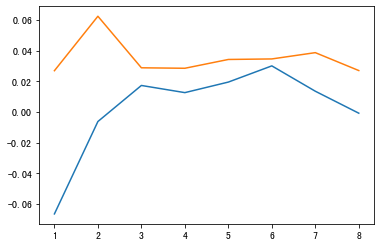

In [43]:
plt.plot(list(range(1, 9)), r_s)
plt.plot(list(range(1, 9)), n_s)

### Question5: What are the characteristics of rumour-creating users, and are they different to normal users? 

In [48]:
user_info = ['user_engagement', 'favourite_rate', 'friends_count']

In [49]:
for i in user_info:
    print(df.groupby('label')[i].mean())

label
0    10352.962607
1    11966.341351
Name: user_engagement, dtype: float64
label
0    2230.548784
1    4156.839072
Name: favourite_rate, dtype: float64
label
0     5728.285312
1    10081.729261
Name: friends_count, dtype: float64


In [50]:
for i in user_info:
    print(df.groupby('label')['reply_'+i].mean())

label
0    5157.341100
1    5476.010299
Name: reply_user_engagement, dtype: float64
label
0    4470.173934
1    5757.007164
Name: reply_favourite_rate, dtype: float64
label
0    1691.493117
1    2008.748081
Name: reply_friends_count, dtype: float64
